In [1]:
import numpy as np
import pandas as pd
import pickle
from skimage.io import imread, imsave
from skimage import img_as_ubyte
from matplotlib import pyplot as plt
from collections import Counter

from platform import python_version

%matplotlib inline

np.__version__, python_version()

('1.18.5', '3.8.3')

### Raw images and input

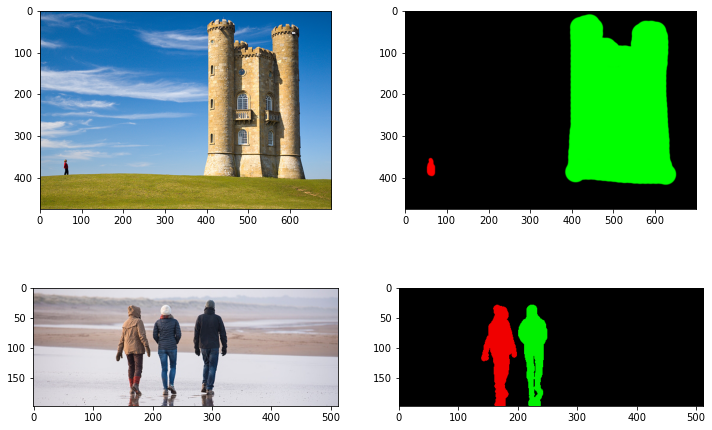

In [2]:
img = imread('tests/01_test_img_input/img.png')
mask = imread('tests/01_test_img_input/mask.png')

plt.figure(figsize=(12,8))

plt.subplot(2, 2, 1)
plt.imshow(img)

plt.subplot(2, 2, 2)
plt.imshow(mask)

img2 = imread('tests/05_test_img_input/img.png')
mask2 = imread('tests/05_test_img_input/mask.png')

plt.subplot(2, 2, 3)
plt.imshow(img2)

plt.subplot(2, 2, 4)
plt.imshow(mask2)

### Shrinking

In [3]:
def get_Y(raw_img):
    img = np.array(raw_img, dtype='float64')
    R, G, B = raw_img[...,0], raw_img[...,1], raw_img[...,2]
    Y = 0.299 * R + 0.587 * G + 0.114 * B
    return Y

def get_derivative(intensity, axis):
    # 1 ~ x, 0 ~ y
    intensity = np.pad(intensity, pad_width=1, mode='edge')
    derivative = (np.roll(intensity, shift=-1, axis=axis) - 
                  np.roll(intensity, shift=1, axis=axis))[1:-1,1:-1]
    return derivative

def get_energy(intensity):
    # energy = norm of gradient
    x_diff = get_derivative(intensity, axis=1)
    y_diff = get_derivative(intensity, axis=0)
    energy = np.sqrt(x_diff ** 2 + y_diff ** 2)
    return energy

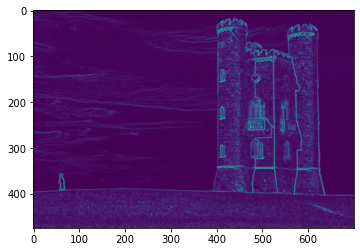

In [4]:
y = get_Y(img)
energy = get_energy(y)
plt.imshow(energy)

In [5]:
def global_index(triplet_index, row_index, max_index):
    # map local index of minimum energy into global index of image
    return {0: max(0, row_index - 1), 
            1: row_index, 
            2: min(row_index + 1, max_index)}[triplet_index]

def get_all_seams(energy):
    h, w = energy.shape
    seams = np.zeros((h, w), dtype='float64')
    seams[0,:] = energy[0,:]
    min_energy_pointers = []
    for i in range(1, h):
        current_row = energy[i,:]
        upper_row = seams[i-1,:]
        minimums, indices = [], []
        for j in range(w):
            triplet = upper_row[max(0, j-1):min(w, j+2)]
            minimums.append(np.min(triplet))
            if j == 0:
                indices.append(np.argmin(triplet))
            else:
                # argmin returns index of the most left minimum if there're many the same
                indices.append(global_index(np.argmin(triplet), j, w-1))
        seams[i,:] += minimums + current_row
        min_energy_pointers.append(indices)
    return seams, np.array(min_energy_pointers, dtype='int')

def get_minimal_seam(seams, min_energy_pointers):
    seam_mask = np.zeros(seams.shape, dtype='uint8')
    current_pointer = np.argmin(seams[-1,:])
    seam_mask[-1,current_pointer] = 1
    # from bottom to top
    for i, row in enumerate(reversed(min_energy_pointers)):
        current_pointer = row[current_pointer]
        seam_mask[-2-i,current_pointer] = 1
    return np.array(seam_mask, dtype='uint8')

In [6]:
test = np.array([[3,4,3,5],
                 [5,4,5,6],
                 [1,1,1,1]])
seams, min_energy_pointers = get_all_seams(test)
seam_mask = get_minimal_seam(seams, min_energy_pointers)
print(seams)
print(min_energy_pointers)
print(seam_mask)

[[3. 4. 3. 5.]
 [8. 7. 8. 9.]
 [8. 8. 8. 9.]]
[[0 0 2 2]
 [1 1 1 2]]
[[1 0 0 0]
 [0 1 0 0]
 [1 0 0 0]]


In [7]:
def apply_mask(raw_img, mask):
    h, w, c = raw_img.shape
    return np.dstack([raw_img[...,i][~mask.astype(bool)].reshape((h, w-1)) for i in range(c)])

def shrink_horizontal(img, mask):
    h, w, _ = img.shape
    y = get_Y(img)
    energy = get_energy(y)
    if mask is not None:
        energy += np.array(mask, dtype='float64') * h * w * 256
    seams, min_energy_pointers = get_all_seams(energy)
    seam_mask = get_minimal_seam(seams, min_energy_pointers)
    shrinked = apply_mask(img, seam_mask)
    if mask is not None:
        mask = mask[~seam_mask.astype(bool)].reshape((h, w-1))
    return shrinked, mask, seam_mask

def rotate_flip(img):
    img = np.rot90(img, axes=(1,0))
    img = np.flip(img, axis=1)
    return img

def rotate_flip_reverse(img):
    img = np.flip(img, axis=1)
    img = np.rot90(img, axes=(0,1))
    return img

def shrink_vertical(img, mask):
    img_rotated = rotate_flip(img)
    if mask is not None:
        mask = rotate_flip(mask)
    shrinked_rotated, mask, seam_mask_rotated = shrink_horizontal(img_rotated, mask)
    shrinked = rotate_flip_reverse(shrinked_rotated)
    seam_mask = rotate_flip_reverse(seam_mask_rotated)
    if mask is not None:
        mask = rotate_flip_reverse(mask)
    return shrinked, mask, seam_mask

### Testing

In [8]:
def make_mask(img, seam_true):
    seam_mask_true = np.zeros(img.shape[:2])
    for row, index in seam_true:
        seam_mask_true[row,index] = 1
    return seam_mask_true

def plot_img_seam(img, seam_mask_predicted, seam_true):
    copy = img.copy()
    seam_mask_true = make_mask(img, seam_true)
    copy[...,0][seam_mask_true.astype(bool)] = 0
    copy[...,1][seam_mask_true.astype(bool)] = 255
    copy[...,2][seam_mask_true.astype(bool)] = 0
    copy[...,0][seam_mask_predicted.astype(bool)] = 255
    copy[...,1][seam_mask_predicted.astype(bool)] = 0
    copy[...,2][seam_mask_predicted.astype(bool)] = 0
    plt.imshow(copy)
    
def convert_img_to_mask(img):
    return ((img[:, :, 0] != 0) * -1 + (img[:, :, 1] != 0)).astype('int8')    

In [9]:
mapping_gt = {0: 'None, shrink, horizontal',
                1: 'None, shrink, vertical',
                2: 'None, expand, horizontal',
                3: 'None, expand, vertical',
                4: 'mask, shrink, horizontal',
                5: 'mask, shrink, vertical',
                6: 'mask, expand, horizontal',
                7: 'mask, expand, vertical'}

seams_true = {}
for k in range(1,8):
    with open(f'tests/0{k}_test_img_gt/seams', 'rb') as f:
        seams_true.update({k: {i: pickle.load(f) for i in range(8)}})

Mask:  Counter({0: 204821, 1: 114934, -1: 7845})
[horizontal] New img: (468, 699, 3) new mask: - seam: (468, 700)
[horizontal] Answer: True
[vertical] New img: (467, 700, 3) new mask: - seam: (468, 700)
[vertical] Answer: True
[horizontal] New img: (468, 699, 3) new mask: (468, 699) seam: (468, 700)
[horizontal] Answer: True
[vertical] New img: (467, 700, 3) new mask: (467, 700) seam: (468, 700)
[vertical] Answer: True


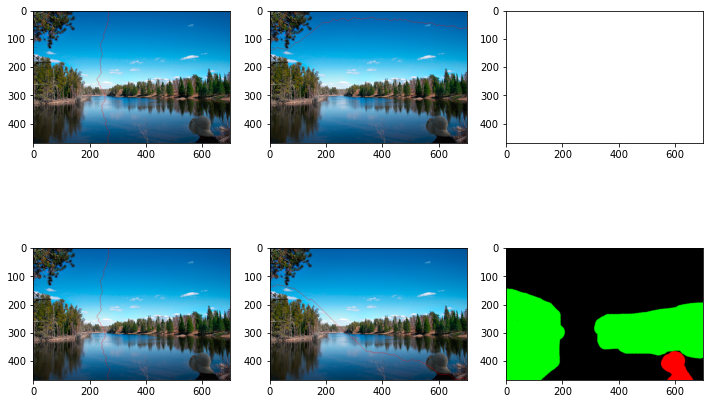

In [14]:
picture = 2

img = imread(f'tests/0{picture}_test_img_input/img.png')
mask_img = imread(f'tests/0{picture}_test_img_input/mask.png')
mask = convert_img_to_mask(mask_img)
original = mask.copy()
print('Mask: ', Counter(mask.flatten()))

def report(func, mask, name, picture, case):
    img_new, mask_new, seam_mask = func(img, mask)
    print(f'[{name}] New img:', img_new.shape,
          'new mask:', mask_new.shape if mask is not None else '-', 
          'seam:', seam_mask.shape)
    print(f'[{name}] Answer:', np.all(seam_mask==make_mask(img, seams_true[picture][case])))
    plot_img_seam(img, seam_mask, seams_true[picture][case])

plt.figure(figsize=(12,8))
plt.subplot(2, 3, 1)
report(shrink_horizontal, None, 'horizontal', picture, 0)
assert np.all(original == mask)
plt.subplot(2, 3, 2)
report(shrink_vertical, None, 'vertical', picture, 1)
assert np.all(original == mask)
plt.subplot(2, 3, 3)
plt.imshow(np.zeros(mask_img.shape))
plt.subplot(2, 3, 4)
report(shrink_horizontal, mask, 'horizontal', picture, 4)
assert np.all(original == mask)
plt.subplot(2, 3, 5)
report(shrink_vertical, mask, 'vertical', picture, 5)
assert np.all(original == mask)
plt.subplot(2, 3, 6)
plt.imshow(mask_img)

### Expanding

In [60]:
def insert_into_array(array, insert_mask, values):
    h, w = array.shape
    array_new = np.zeros((h,w+1))
    for i in range(h):
        array_new[i] = np.insert(array[i], 
                                 np.where(insert_mask[i])[0][0], 
                                 values[i])
    return array_new

def insert_new_seam(raw_img, seam_mask):
    h, w, c = raw_img.shape
    img = np.array(raw_img, dtype='float64')
    last_column = seam_mask[:,-1:]
    seam_mask_padded = np.hstack([seam_mask, last_column])
    neighbour_mask = np.roll(seam_mask_padded, shift=1, axis=1)[:,:-1]
    img_channels = []
    for ch in range(c):
        channel = img[...,ch]
        new_seam_values = (channel[seam_mask.astype(bool)] + 
                           channel[neighbour_mask.astype(bool)]) / 2
        channel_new = insert_into_array(channel, neighbour_mask, new_seam_values)
        img_channels.append(channel_new)
    img_new = np.array(np.dstack(img_channels), dtype='uint8')
    return img_new, neighbour_mask

def expand_horizontal(img, mask):
    h, w, _ = img.shape
    y = get_Y(img)
    energy = get_energy(y)
    if mask is not None:
        energy += np.array(mask, dtype='float64') * h * w * 256
    seams, min_energy_pointers = get_all_seams(energy)
    seam_mask = get_minimal_seam(seams, min_energy_pointers)
    img_new, neighbour_mask = insert_new_seam(img, seam_mask)
    if mask is not None:
        mask = mask + seam_mask 
        mask = insert_into_array(mask, neighbour_mask, np.zeros(h))
    return img_new, mask, seam_mask

def expand_vertical(img, mask):
    img_rotated = rotate_flip(img)
    if mask is not None:
        mask = rotate_flip(mask)
    expanded_rotated, mask, seam_mask_rotated = expand_horizontal(img_rotated, mask)
    expanded = rotate_flip_reverse(expanded_rotated)
    seam_mask = rotate_flip_reverse(seam_mask_rotated)
    if mask is not None:
        mask = rotate_flip_reverse(mask)
    return expanded, mask, seam_mask

### Testing

Mask:  Counter({0: 91348, -1: 5168, 1: 4860})
[horizontal] New img: (198, 513, 3) new mask: - seam: (198, 512)
[horizontal] Answer: True
[vertical] New img: (199, 512, 3) new mask: - seam: (198, 512)
[vertical] Answer: True
[horizontal] New img: (198, 513, 3) new mask: (198, 513) seam: (198, 512)
[horizontal] Answer: True
[vertical] New img: (199, 512, 3) new mask: (199, 512) seam: (198, 512)
[vertical] Answer: True


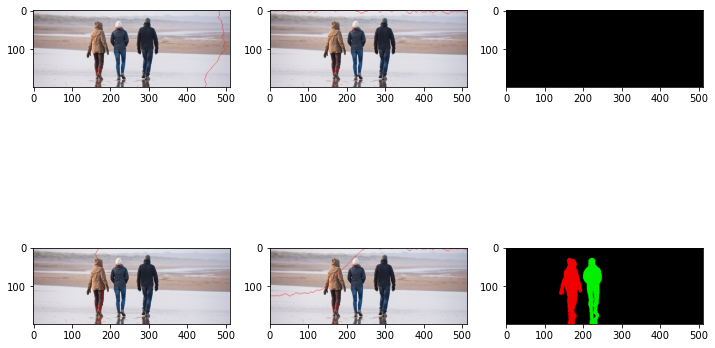

In [61]:
picture = 5

img = imread(f'tests/0{picture}_test_img_input/img.png')
mask_img = imread(f'tests/0{picture}_test_img_input/mask.png')
mask = convert_img_to_mask(mask_img)
original = mask.copy()
print('Mask: ', Counter(mask.flatten()))

plt.figure(figsize=(12,8))
plt.subplot(2, 3, 1)
report(expand_horizontal, None, 'horizontal', picture, 2)
assert np.all(original == mask)
plt.subplot(2, 3, 2)
report(expand_vertical, None, 'vertical', picture, 3)
assert np.all(original == mask)
plt.subplot(2, 3, 3)
plt.imshow(np.zeros(mask_img.shape))
plt.subplot(2, 3, 4)
report(expand_horizontal, mask, 'horizontal', picture, 6)
assert np.all(original == mask)
plt.subplot(2, 3, 5)
report(expand_vertical, mask, 'vertical', picture, 7)
assert np.all(original == mask)
plt.subplot(2, 3, 6)
plt.imshow(mask_img)